In [5]:
import io 
from os import listdir
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.porter import *
import re 
import string
from langdetect import detect
import langdetect
import pandas
from collections import defaultdict
import pickle
import ast
import os
import math
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt
import matplotlib
from nameparser import HumanName
import numpy as np
import string
import seaborn as sns
from statistics import mean
from PIL import Image

In [6]:
DATA_PATH = 'data/Top50/reviews'
DATA_PATH_ENGLISH = 'data/Top50/reviews/English_Only'
DATA_PATH_PICKLES = 'data/Top50/reviews/Pickles'
DATA_PATH_NAMES = 'data/Top50/reviews/Names'
DATA_PATH_HOSTS = 'data/Top50/hosts'
DATA_PATH_CITY_IMAGES = 'data/Images'
citynames = [f[:-19] for f in os.listdir(DATA_PATH_ENGLISH)]
fileNamesEnglishOnly = [f for f in os.listdir(DATA_PATH_ENGLISH)]

In [7]:
def writeFile(f, fname):
#The function writes a pickle file storing the element given in input.
    with open('data/Top50/reviews/Pickles/' + fname, 'wb') as handle:
        pickle.dump(f, handle, protocol = pickle.HIGHEST_PROTOCOL)

def readFile(fname, path = DATA_PATH_PICKLES):
#The function read a pickle file and return the related structure.
    res = None
    with open(path + '/' + fname, 'rb') as handle:
        res = pickle.load(handle)
    return res

# Text Parsing 


In [8]:
def CreateFiles_WithEnglishReviewsOnly(path = DATA_PATH):
    # go through files in directory and create equivalent ones where the elements where the reviews and response were not in English are 0
    # creates dictionary with the count of languages the reviews (hopefullt this means users) for each city
    # creates dictionary with the response percentage for each user

    language_count = {}
    response_frequency = defaultdict(int)
    times_user_was_reviewed = defaultdict(int)
    files = [f for f in listdir(path) if os.path.isfile(path+'/'+f) == True]
    for file in files:
        #eliminate Rev.txt part at the end
        CityName = file[:-7]
        language_count[CityName] = defaultdict(int)
        CityReviews_DataFrame = pandas.read_csv(path +'/'+file, encoding='utf-8', engine='c')

        # populate dict with users and how many times they were reviewed
        for user, number_reviews in CityReviews_DataFrame['to'].value_counts().items():
                times_user_was_reviewed[user] += number_reviews

        i = 0
        for index, row in CityReviews_DataFrame.iterrows():

            try:
                id_user_reviewed = row['to']
                languageOfReview = detect(row['text'])
                if languageOfReview == 'en':
                    language_count[CityName]['en'] += 1

                else:
                    #put review to  0 and add to dictionary this language count
                    CityReviews_DataFrame['text'][index] = 0
                    language_count[CityName][languageOfReview] += 1  

                # not nan
                if len(str(row['response'])) > 4:
                    response_frequency[id_user_reviewed] += 1                 
                i += 1

            except langdetect.lang_detect_exception.LangDetectException as k: #and pandas.errors.ParserError:
                pass 

            if(i%500 == 0):      
                print(i,'/',len(CityReviews_DataFrame))

        CityReviews_DataFrame.to_csv(path + '/English_Only/' + CityName + "Rev_EnglishOnly.csv")
        print("Done with %s" %(file))

    # divide to make frequency
    for key,value in response_frequency.items():
        response_frequency[key] = value / times_user_was_reviewed[key]

    writeFile(language_count, "Language_count_dict.pickle")
    writeFile(response_frequency, "Response_Frequency_dict.pickle")
    
def Concact(path = DATA_PATH_HOSTS):
#concatinate files
    files = [f for f in listdir(path)]
    rev = pandas.DataFrame() #creates a new dataframe that's empty
    for file in  files:
        df = pandas.read_csv(path +'/'+ file ,index_col=False)
        rev = pandas.concat([rev,df]).reset_index(drop=True)

    rev=rev.drop_duplicates()
    rev.to_csv(path + '/ConcactinatedHosts.csv',index = False)

    
def ParseReviews (selpath = DATA_PATH_ENGLISH):
#filter review content and save/output dictionary with city as key and the words in the reviews there
#can use it to create dictionary with users and words received in the reviews when necessary

    files =[f for f in os.listdir(path)]
    StopWords = set(stopwords.words('english'))
    Stemmer = nltk.stem.PorterStemmer()

    for file in files:
        CityReviews_DataFrame = pandas.read_csv(path +'/'+file, encoding='utf-8', engine='c')
        words = []
        #words_stemmed = []
        CityName = file[:-19]
        i = 0
        for index, row in CityReviews_DataFrame.iterrows():
            tokens = word_tokenize(row['text'])
            for word in tokens:
                word = word.lower()
                if not bool(re.search("[^A-Za-z]",word)) and word not in StopWords:
                    words.append(word)
                    #words_stemmed.append(Stemmer.stem(word))
            i += 1
            if (i%500 == 0): 
                print(i)
        print("Done with %s" %(CityName))
        WordFrequencyDistribution_PerCity[CityName] = nltk.FreqDist(words)

    writeFile(WordFrequencyDistribution_PerCity, "WordFrequencyDistribution_PerCity_dict.pickle")



# DATA STRUCTURES

In [9]:
def CreateInvertedIndex (word_distribution_percity = 'WordFrequencyDistribution_PerCity_dict.pickle'):
# create data structure (dictionary) to easily access each word and see in which city reviews it appears for calculation of TF-IDF 

    WordFrequencyDistribution_PerCity = readFile(word_distribution_percity)

    i = 0
    
    for city,freqDist in WordFrequencyDistribution_PerCity.items():
        number_of_words_in_city = sum(freqDist.values())
        for word,tf in freqDist.items():
            try:
                self.invertedIndex[word][1][city] = tf/number_of_words_in_city

            except KeyError as k:
                invertedIndex[word] = [None, {city:tf/number_of_words_in_city}]

        i += 1
        print('%s Cities done' %(i))

    NumberOfCities = 20
    for word, pair in invertedIndex.items():
        #base 10
        pair[0] = math.log(NumberOfCities/len(pair[1]),10)

    self.writeFile(invertedIndex, 'InvertedIndex.pickle')
    print("Inverted Index Saved")
    
def CalculateSentimentofEachReview (path = DATA_PATH_ENGLISH):
# creates dictionary with keys : review id (which we can then link to each specific user) and review sentiment as value
#False as a value means the review had no relevant words to do sentiment analysis on, None means no English

    self.SentimentPerReview = defaultdict(float)
    SentimentDataSet = pandas.read_csv('data/SentimentAnalysis/Data_Set_S1.csv')
    files = [f for f in os.listdir(path)]
    StopWords = set(stopwords.words('english'))
    Punctuation = set(string.punctuation)


    for file in files:
        CityReviews_DataFrame = pandas.read_csv(path +'/'+file, encoding='utf-8', engine='python')
        print('Beggining %s' %(file))
        i = 0
        for index,row in CityReviews_DataFrame.iterrows():

            if row['text'] != '0':
                temp_text = "".join(word for word in row['text'] if word not in Punctuation)
                words = []
                tokens = word_tokenize(temp_text)

                for word in tokens:
                    word = word.lower()
                    if not bool(re.search("[^A-Za-z]",word)) and word not in StopWords:
                        words.append(word) 


                Sentiment = float(0)
                divide_by = 0
                for word in words:
                    if word in list(SentimentDataSet['word']):
                        Sentiment += SentimentDataSet['happiness_average'][np.where(SentimentDataSet["word"] == word)[0][0]] 
                        divide_by += 1

                if divide_by != 0:

                    Sentiment /= divide_by
                    self.SentimentPerReview[row['id']] = Sentiment  
                else:
                    self.SentimentPerReview[row['id']] = False

            else:
                self.SentimentPerReview[row['id']] = None     


            i +=1
            if (i%1000 == 0):
                (print(i))

    self.writeFile(self.SentimentPerReview, 'SentimentPerReview_Dict.pickle')

def CreateDictionaryforSentimentPerUser (self):
#takes previously created dictionary and creates a new one that user is the keys, as values we will have another dictionary that has overall average sentiment on the reviews for that user
# the average sentiment received as a surfer and the average sentiment received as a host


    SentimentPerReview = self.readFile('SentimentPerReview_Dict.pickle')

    SentimentPerUser = {}
    ValueDictionary = defaultdict(float)
    ReviewsOfEachUser = defaultdict(list)
    ReviewsOfEachUser_asHost = defaultdict(list)
    ReviewsOfEachUser_asSurfer = defaultdict(list)
    ConcatinatedReviews_DataFrame = pandas.read_csv('data/Top50/reviews/English_Only/EnglishConcact.csv')
    TimesUserWasReviewed = defaultdict(float)
    TimesUserWasReviewed_asHost = defaultdict(float)
    TimesUserWasReviewed_asSurfer = defaultdict(float)

    #get review ID's of each user
    #get amount of times user was reviewed both in general and as a surfer and as a host
    for index, row in ConcatinatedReviews_DataFrame.iterrows():
        if row['text'] != '0':
            ReviewsOfEachUser[row['to']].append(row['id'])
            TimesUserWasReviewed[row['to']] += 1
            if row['relationshipType'] == 'surf':
                TimesUserWasReviewed_asHost[row['to']] += 1
                ReviewsOfEachUser_asHost[row['to']].append(row['id'])

            elif row['relationshipType'] == 'host':
                TimesUserWasReviewed_asSurfer[row['to']] += 1
                ReviewsOfEachUser_asSurfer[row['to']].append(row['id'])

    for user in ReviewsOfEachUser.keys():
        UserValueDictionary = defaultdict(float)
        for review in ReviewsOfEachUser[user]:
            UserValueDictionary['overall'] += SentimentPerReview[review]
            if review in ReviewsOfEachUser_asHost[user]:
                UserValueDictionary['as_Host'] += SentimentPerReview[review]
            elif review in ReviewsOfEachUser_asSurfer[user]:
                UserValueDictionary['as_Surfer'] += SentimentPerReview[review]

        UserValueDictionary['overall'] /= TimesUserWasReviewed[user]
        if  UserValueDictionary['as_Host'] > 0:
            UserValueDictionary['as_Host'] /= TimesUserWasReviewed_asHost[user]
        if UserValueDictionary['as_Surfer'] > 0:
            UserValueDictionary['as_Surfer'] /= TimesUserWasReviewed_asSurfer[user] 

        SentimentPerUser[user] = UserValueDictionary

    self.writeFile(SentimentPerUser, 'SentimentPerUser.pickle')


# PLOTTING

In [79]:
def PlotPositiveNegative_Experiences_PerCity (path = DATA_PATH):
    #saves figure with ratio of negative over positive ratio of reviews per cirtyf
    PositiveNegativeNeutral_Count = defaultdict(list)
    NegativePositive_Ratio = defaultdict(float)
    files = [f for f in listdir(path) if os.path.isfile(path+'/'+f) == True]
    for file in files:
        dataFrametoPlot1 = pandas.DataFrame()
        CityName = file[:-7]
        CityReviews_DataFrame = pandas.read_csv(path +'/'+ file, encoding='utf-8', engine='c')
        #experiences can be positive, negative or neutral
        for type_of_experience,  count in CityReviews_DataFrame['experience'].value_counts().items():
            PositiveNegativeNeutral_Count[CityName].append((type_of_experience,count))
            #if type_of_experience.lower() == "positive":

    for key,value in PositiveNegativeNeutral_Count.items():
        NegativePositive_Ratio[key] = (value[1][1] / value[0][1]) * 100

    dataFrametoPlot = pandas.DataFrame()
    for city,NegPosRatio in NegativePositive_Ratio.items():
        dataFrametoPlot[city] = [NegPosRatio]
        #print(NegPosRatio)

    #print(dataFrametoPlot)
    plt.figure (figsize = (22,8))
    sns.barplot(data = dataFrametoPlot)
    #sns.swarmplot(data=dataFrametoPlot, color=".25")
    plt.title("Ratio of Negative to Positive Experiences (% of Negative/Positive)")
    plt.ylabel(" Ratio of Negative to Positive Experiences ")
    plt.savefig('plots/NegativePositiveExperiencesRatio', transparent = True)  


def GetCityWordcloudsTFIDF(path = DATA_PATH_ENGLISH, invertedIndex = 'InvertedIndex.pickle'):
#create a dictionary of words(keys) and TF-IDF(value) of each city and then do a wordcloud according to that

    invertedIndex = readFile(invertedIndex)
    citynames = [f[:-19] for f in os.listdir(path)]
    citynames.pop(13)
    for city in citynames:
        cityDictionary = {}
        for word,pair in invertedIndex.items():
            if city in pair[1].keys():  # and word not in self.names:
                cityDictionary[word] = pair[0] * pair[1][city]
                
        print(city)
                
        coloring = np.array(Image.open(('data/Images/speak.png')))
        wc = WordCloud(background_color="white", mask=coloring,max_font_size=40, random_state=42)

        # generate word cloud
        wc.generate_from_frequencies(cityDictionary)

        # create coloring from image
        image_colors = ImageColorGenerator(coloring)
        plt.figure( figsize=(20,20))
        plt.imshow(wc.recolor(color_func=image_colors), interpolation="bilinear")
        plt.axis('off')
        plt.savefig('wordclouds/' + city +'bubble') 
        
def GetCityWordcloudsTF(path = DATA_PATH_ENGLISH, invertedIndex = 'InvertedIndex.pickle'):
#create a dictionary of words(keys) and TF-IDF(value) of each city and then do a wordcloud according to that

    invertedIndex = readFile(invertedIndex)
    citynames = [f[:-19] for f in os.listdir(path)]
    citynames.pop(13)
    for city in citynames:
        cityDictionary = {}
        for word,pair in invertedIndex.items():
            if city in pair[1].keys():  # and word not in self.names:
                cityDictionary[word] = pair[1][city]
                
        print(city)
                
        coloring = np.array(Image.open(('data/Images/speak(1).png')))
        wc = WordCloud(background_color="white", mask=coloring,max_font_size=40, random_state=42)

        # generate word cloud
        wc.generate_from_frequencies(cityDictionary)

        # create coloring from image
        image_colors = ImageColorGenerator(coloring)
        plt.figure( figsize=(20,20))
        plt.imshow(wc.recolor(color_func=image_colors), interpolation="bilinear")
        plt.axis('off')
        plt.savefig('wordclouds/' + city +'bubble_TFOnly_test') 
        
def GetCityWordcloudsBadGoodReviews(path = DATA_PATH_ENGLISH, invertedIndex = 'InvertedIndex.pickle'):
#create a dictionary of words(keys) and TF-IDF(value) of each city and then do a wordcloud according to that
    
    StopWords = set(stopwords.words('english'))
    Stemmer = nltk.stem.PorterStemmer()
    SentimentPerReview = readFile('SentimentPerReview_Dict.pickle')
    ConcatinatedDataFrame = pandas.read_csv('data/Top50/reviews/Concatinated/EnglishConcact.csv')
    negative_words = []
    positive_words = []
    # get standard deviation but already have the box plots for reference

    for reviewId, sentiment in SentimentPerReview.items():
        if sentiment!= None and sentiment != False and float(sentiment) < 4.5:
            tokens = word_tokenize(ConcatinatedDataFrame['text'][np.where(ConcatinatedDataFrame['id'] == reviewId)[0][0]])
            for word in tokens:
                word = word.lower()
                if not bool(re.search("[^A-Za-z]",word)) and word not in StopWords:
                    negative_words.append(word)
        
    
        if sentiment!= None and sentiment != False and float(sentiment) > 7:
            tokens = word_tokenize(ConcatinatedDataFrame['text'][np.where(ConcatinatedDataFrame['id'] == reviewId)[0][0]])
            for word in tokens:
                word = word.lower()
                if not bool(re.search("[^A-Za-z]",word)) and word not in StopWords:
                    positive_words.append(word)
        
    negative_dictionary = dict(nltk.FreqDist(negative_words))
    positive_dictionary = dict(nltk.FreqDist(positive_words))

    coloring_bad = np.array(Image.open(('data/Images/thumb-down.png')))
    coloring_good = np.array(Image.open(('data/Images/like.png')))
    wc_bad = WordCloud(background_color="white", mask=coloring_bad, max_words = 100,max_font_size=40, random_state=42)
    wc_good = WordCloud(background_color="white", mask=coloring_good, max_words = 100, max_font_size=40, random_state=42)
        
    print("                Worclouds for Negative (sentiment below 4.5) and Positive Reviews (above 7) \n\n")

    # generate word cloud
    wc_bad.generate_from_frequencies(negative_dictionary)
    wc_good.generate_from_frequencies(positive_dictionary)

    # create coloring from image
    image_colors_negative = ImageColorGenerator(coloring_bad)
    image_colors_positive = ImageColorGenerator(coloring_good)

    fig, axes = plt.subplots(1,2,figsize=(20,20))
    # recolor wordcloud and show
    # we could also give color_func=image_colors directly in the constructor
    axes[0].imshow(wc_bad.recolor(color_func=image_colors_negative), interpolation="bilinear")
    axes[1].imshow(wc_good.recolor(color_func=image_colors_positive), interpolation="bilinear")
    for ax in axes:
        ax.set_axis_off()
    plt.show()
    plt.savefig('wordclouds/' + 'Good and Bad') 


def plotSentimentBoxGraph (dict ='SentimentPerUser.pickle'):

    SentimentPerUser = readFile(dict)
    OverallSentiment = []
    SurfingSentiment = []
    HostingSentiment = []

    dataFrametoPlot = pandas.DataFrame()



    for user in SentimentPerUser.keys():

        OverallSentiment.append(float(SentimentPerUser[user]['overall']))
        SurfingSentiment.append(float(SentimentPerUser[user]['as_Surfer']))
        HostingSentiment.append(float(SentimentPerUser[user]['as_Host']))

    SurfingSentiment = [elem for elem in SurfingSentiment if elem != 0.0]
    SurfingSentiment = pandas.Series(SurfingSentiment)
    HostingSentiment = [elem for elem in HostingSentiment if elem != 0.0]
    HostingSentiment = pandas.Series(HostingSentiment)
    OverallSentiment = [elem for elem in OverallSentiment if elem != 0.0]
    OverallSentiment = pandas.Series(OverallSentiment)
    
    dataFrametoPlot['Sentiment as Host'] = HostingSentiment
    dataFrametoPlot['Sentiment as Surfers'] = SurfingSentiment
    dataFrametoPlot['Overall Sentiment'] = OverallSentiment



    plt.figure()
    sns.boxplot( data = dataFrametoPlot)
    sns.swarmplot(data=dataFrametoPlot, color=".25")
    plt.ylabel("Sentiment \n")
    
    plt.savefig('plots/SentimentDistributionWithSwarm', transparent = True)      


    #but I also want to see the correlation between surf reviewns and host reviews

def plotAvgSentimentPerCity (self, dict = 'SentimentPerReview_Dict.pickle', path = DATA_PATH_ENGLISH):

    SentimentPerReview = self.readFile(dict)
    dataFrametoPlot = pandas.DataFrame()
    files = os.listdir(path)

    for file in files:
        CityName = file [:-19]
        CityReviews_DataFrame = pandas.read_csv(path + '/' +file)
        sum = []

        for index, row in CityReviews_DataFrame.iterrows():
            if SentimentPerReview[row['id']] != None and SentimentPerReview[row['id']] != False:
                sum.append(SentimentPerReview[row['id']])

        sum = pandas.Series(mean(sum))
        dataFrametoPlot[CityName] = [sum]
        print("Done with %s" %(CityName))

    plt.figure(figsize = (22,8))
    #plt.figsize(12,20)
    sns.barplot(data = dataFrametoPlot)
    #sns.swarmplot(data=dataFrametoPlot, color=".25")
    plt.title("Average Sentiment Per City")
    plt.ylabel("Average Sentiment \n")
    plt.savefig('plots/AvgSentimentPerCityBig', transparent = True)      

def plotEvolutionOfSentimentOvertimeGeneral(self, dict = 'SentimentPerReview_Dict.pickle', path = DATA_PATH):

    SentimentPerReview = self.readFile(dict)
    ConcatinatedReviews_DataFrame = pandas.read_csv(path + '/Concatinated/EnglishConcact.csv')
    years_reviews = defaultdict(list)
    dataFrametoPlot = pandas.DataFrame()

    for index, row in ConcatinatedReviews_DataFrame.iterrows():
        if SentimentPerReview[row['id']] != None and SentimentPerReview[row['id']] != False:
            years_reviews[str(row['createdDate'])[0:4]].append(SentimentPerReview[row['id']])


    for year, SentimentofReviews in years_reviews.items():
        years_reviews[year] = mean(SentimentofReviews)

    sentiment = list(years_reviews.values())[::-1]
    sentiment[4], sentiment[5] = sentiment[5], sentiment[4]
    years = list(years_reviews.keys())[::-1]
    years[4], years[5] = years[5], years[4]
    plt.figure(figsize = (22,8))
    plt.plot(years,sentiment)
    plt.title("Evolution of Sentiment Over Time")
    plt.ylabel("Sentiment \n")
    plt.savefig('plots/EvolutionofSentimentCorrectOrder', transparent = True )      

def plotEvolutionOfSentimentOvertimeEachCity(self, dict = 'SentimentPerReview_Dict.pickle', path = DATA_PATH):

    SentimentPerReview = self.readFile(dict)
    files = os.listdir(path + "/English_Only")

    for file in files:
        city_reviews = defaultdict(list)
        dataFrametoPlot = pandas.DataFrame()
        CityName = file[:-19]
        CityDataframe = pandas.read_csv(path + "/English_Only/" + file)
        for index, row in CityDataframe.iterrows():
            if SentimentPerReview[row['id']] != None and SentimentPerReview[row['id']] != False:
                city_reviews[str(row['createdDate'])[0:4]].append(SentimentPerReview[row['id']])

        years = []
        sort_years = sorted(city_reviews.items(), key=lambda kv: kv[0])
        for year, SentimentofReviews in sort_years:
            years.append(year)
            SentimentofReviews = mean(SentimentofReviews)
            dataFrametoPlot[year] = [SentimentofReviews]

        #sentiment = []
        #years = []
        #sort_years = sorted(city_reviews.items(), key=lambda kv: kv[0])
        #for year, averageSentimentofThatyear in sort_years:
        #    years.append(year)
        #    sentiment.append(averageSentimentofThatyear)

        #sentiment = list(city_reviews.values())[::-1]
        #sentiment[4], sentiment[5] = sentiment[5], sentiment[4]
        #years = list(city_reviews.keys())[::-1]
        #years[4], years[5] = years[5], years[4]

        plt.figure(figsize = (22,8))
        sns.regplot(x = years, y = ['Sentiment mean'] * len(years), data = dataFrametoPlot)
        plt.title("Evolution of Sentiment Over Time in %s" %(CityName))
        plt.ylabel("Sentiment \n")
        plt.savefig('plots/CitiesEvolutionofSentiment/%s with sns' %(CityName), transparent = True ) 



#def plotHeatMapofSimilarityBetweenCities (self,)

# def plotOnlyHostsandSurfers (self, pickle = 'SentimentPerUser.pickle', path = DATA_PATH_HOSTS + '/ConcactinatedHosts.csv'):
#since we only have info on the hosts of each city we can only plot, percentage wise, the members (hosts) that we have information on
# within europe(the cities we consider) do they tend to be hosts only surfs only or both

#def plotWordcloudsOfReviewsWithBestAndWorseSentiemtn or maybe just show the reviews?

#def getSpecificUsersWordclouds
#def getTopHostsWordcloudsFor Reviews Received
#def getwordcluds for reviews of hosts and reviews of surfers








                Worclouds for Negative (sentiment below 4.5) and Positive Reviews (above 7) 




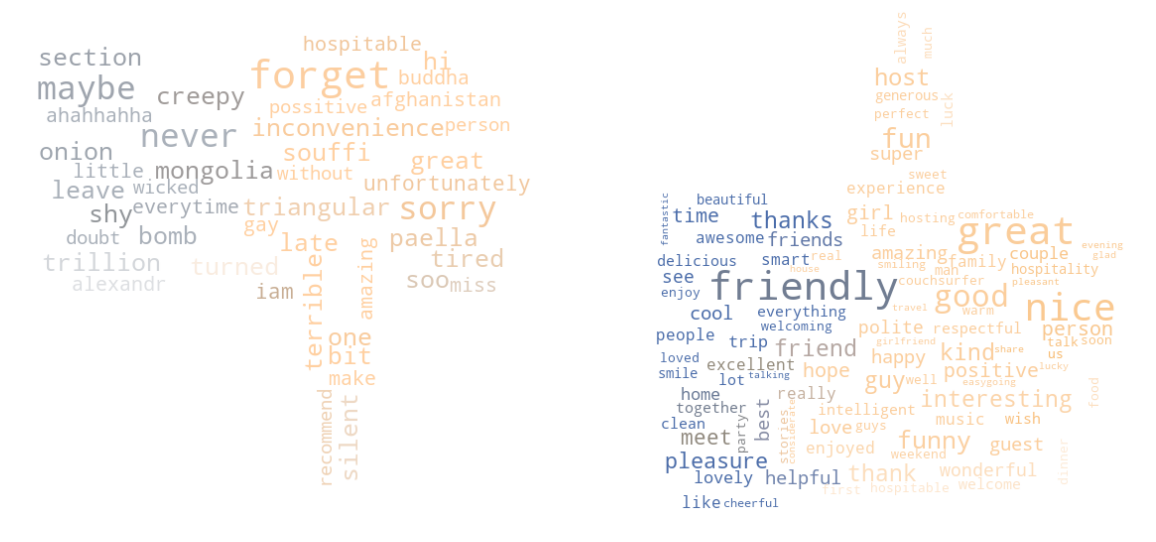

<Figure size 432x288 with 0 Axes>

In [80]:
GetCityWordcloudsBadGoodReviews()